# Deep Learning

## Aufgabem
1. _Laden der Daten und Splitting in Trainings- und Testdaten (Verhältnis 75:25)._
2. _Überlegen Sie sich eine geeignete Netzwerkarchitektur für die Klassifikationsaufgabe._
3. _Implementieren Sie Ihr Netzwerk in Keras/Tensorflow._
4. _Wahlen Sie eine geeignete Loss-Funktion und einen geeigneten Optimizer. Begründen Sie Ihre
Auswahl in Ihrem Kurzreport._
5. _Evaluieren Sie Ihr ML-System und stellen Sie die Ergebnisse in geeigneter Weise dar. Nutzen Sie
zur Evaluation eine Kreuzvalidierung (3-fold)._
6. _In dem Notebook `transfer_learning.ipynb`_

### Laden der Daten und Splitting in Trainings- und Testdaten (Verhältnis 75:25)
Dieser Schritt ist identisch bei _Merkmalsbasierte Klassifikation_ und _Deep Learning_ und wurde somit in `setup.py` ausgelagert.
Dort wird das Verhältnis durch `split=['train[75%:]', 'test[:25%]']` erstellt.


In [20]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import sys
%matplotlib inline


notebook_dir = Path().resolve()
sys.path.append(str(notebook_dir.parent))
from setup import setup_dataset

keras.utils.set_random_seed(0)

verification_image_dir = '../dataset/verification'
model_folder = 'models/'
model_filename = 'dog_classifier.keras'
weights_filename = 'model.weights.h5'

## Hyperparameter definieren

In [21]:
num_classes = 5
batch_size = 16
epochs = 5
learning_rate = 0.001
resize_size = (256, 256)
indices = [0, 2, 77, 84, 55]

## Laden der Datensets

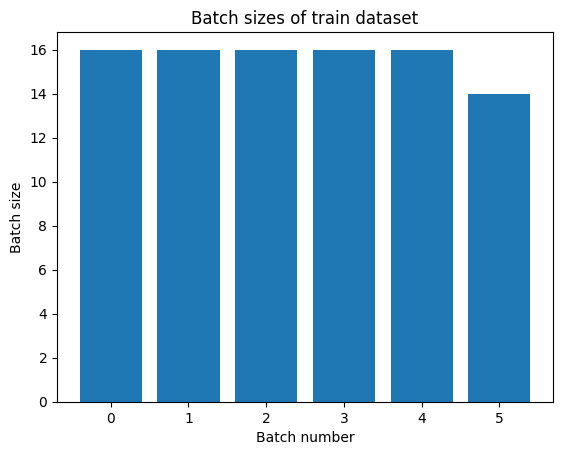

In [22]:
train_dataset, test_dataset, metadata = setup_dataset('../dataset', labels=indices)


def preprocess(img, label):
    table = tf.lookup.StaticHashTable(
        initializer=tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant(indices, dtype=tf.int64),
            values=tf.constant(list(range(num_classes)),  dtype=tf.int64),
        ),
        default_value= tf.constant(0,  dtype=tf.int64)
    )
    img = tf.image.resize(img, resize_size)
    img = img / 255.0  # Normalisierung
    label = table.lookup(label)
    return img, label

train_dataset = (
    train_dataset
        .map(preprocess)
        .shuffle(100)
        .batch(batch_size)
        .repeat(3)
        .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_dataset
        .map(preprocess)
        .shuffle(100)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
)



def plot_batch_sizes(ds):
    batch_sizes = [np.array(batch[1]).shape[0] for batch in ds]
    plt.bar(range(len(batch_sizes)), batch_sizes)
    plt.title("Batch sizes of train dataset")
    plt.xlabel("Batch number")
    plt.ylabel("Batch size")
    plt.show()

plot_batch_sizes(test_dataset)

# Model erstellen

In [23]:

model = keras.models.Sequential(
    [
        keras.layers.Conv2D(64, (7, 7), kernel_initializer='he_uniform', activation='relu', input_shape=(*resize_size, 3)),
        #keras.layers.Conv2D(64, (3, 3), kernel_initializer='he_uniform', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(3,3)),

        keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_uniform', activation='relu'),
        keras.layers.Conv2D(128, (3, 3), kernel_initializer='he_uniform', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(3,3)),

        keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_uniform', activation='relu'),
        keras.layers.Conv2D(256, (3, 3), kernel_initializer='he_uniform', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(3,3)),

        keras.layers.Flatten(),

        keras.layers.Dense(100, activation="relu"),

        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model.compile(
    optimizer=keras.optimizers.SGD(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

## Training des Models

In [19]:

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    verbose=1
)

#model.save_weights(os.path.join(model_folder, weights_filename))
#model.save(os.path.join(model_folder, model_filename))

model.summary()
loss, acc = model.evaluate(test_dataset, verbose=0)
print('Test accuracy: %.3f' % acc)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 6))
fig.suptitle('Accuracy and Loss during Training')

# Plot Accuracy
ax1.set_title("Accuracy")
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Test Accuracy')
ax1.set(xlabel="epochs")
ax1.legend()

# Plot Loss
ax2.set_title("Loss")
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Test Loss')
ax2.set(xlabel="epochs")
ax2.legend()

plt.show()

Epoch 1/5
     27/Unknown 30s 1s/step - accuracy: 0.2295 - loss: 2.4549

/Users/jannisgehring/VSCode/ml-lecture/.venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2303 - loss: 2.4362 - val_accuracy: 0.2766 - val_loss: 1.6660
Epoch 2/5
19/27 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.3671 - loss: 1.5404

# Performancetest des Modells

In [72]:
model = keras.models.load_model(os.path.join(model_folder, model_filename))
print("Model loaded successfully!")

# Step 2: Define Class Labels
# Ensure these match the class labels used during training
class_labels = {
    0: "Chihuahua",
    1: "Maltese Dog",
    2: "Komondor",
    3: "German Shepherd",
    4: "African Hunting Dog"
}
print("Class labels:", class_labels)

# Step 3: Define Image Preprocessing Function
def preprocess_image(img):
    img_array = tf.image.resize(img, resize_size)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Step 4: Predict Function
def predict_image(img):
    preprocessed_image = preprocess_image(img)
    predictions = model.predict(preprocessed_image)
    predicted_class = np.argmax(predictions, axis=-1)[0]
    predicted_label = class_labels[predicted_class]

    # Display the image with its prediction
    img = keras.preprocessing.image.load_img(img)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()
    print(f"Predicted Label: {predicted_label}")

for img in train_dataset:
    print(f"Testing image: {img}")
    predict_image(img)


Model loaded successfully!
Class labels: {0: 'Chihuahua', 1: 'Maltese Dog', 2: 'Komondor', 3: 'German Shepherd', 4: 'African Hunting Dog'}
Testing image: (<tf.Tensor: shape=(33, 256, 256, 3), dtype=float32, numpy=
array([[[[0.16206037, 0.2444133 , 0.12102176],
         [0.2108216 , 0.28572303, 0.15905792],
         [0.2515871 , 0.32665944, 0.19948162],
         ...,
         [0.06834915, 0.20909837, 0.6489719 ],
         [0.07432801, 0.20360191, 0.5709043 ],
         [0.06896548, 0.19655433, 0.5554315 ]],

        [[0.1615554 , 0.24117395, 0.10368724],
         [0.17215995, 0.24171112, 0.10375306],
         [0.22076668, 0.29054046, 0.15191458],
         ...,
         [0.14684197, 0.27693033, 0.57623327],
         [0.14047487, 0.25670034, 0.4956449 ],
         [0.10564797, 0.21901347, 0.4507077 ]],

        [[0.15462449, 0.22065543, 0.07947896],
         [0.16651851, 0.2358353 , 0.08690508],
         [0.22406311, 0.28617248, 0.139803  ],
         ...,
         [0.04697732, 0.14130841, 0

InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:GPU:0}} Shapes of all inputs must match: values[0].shape = [33,256,256,3] != values[1].shape = [33,5] [Op:Pack] name: images